In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import scipy.fftpack as fftpack

(3200, 3500, 3)


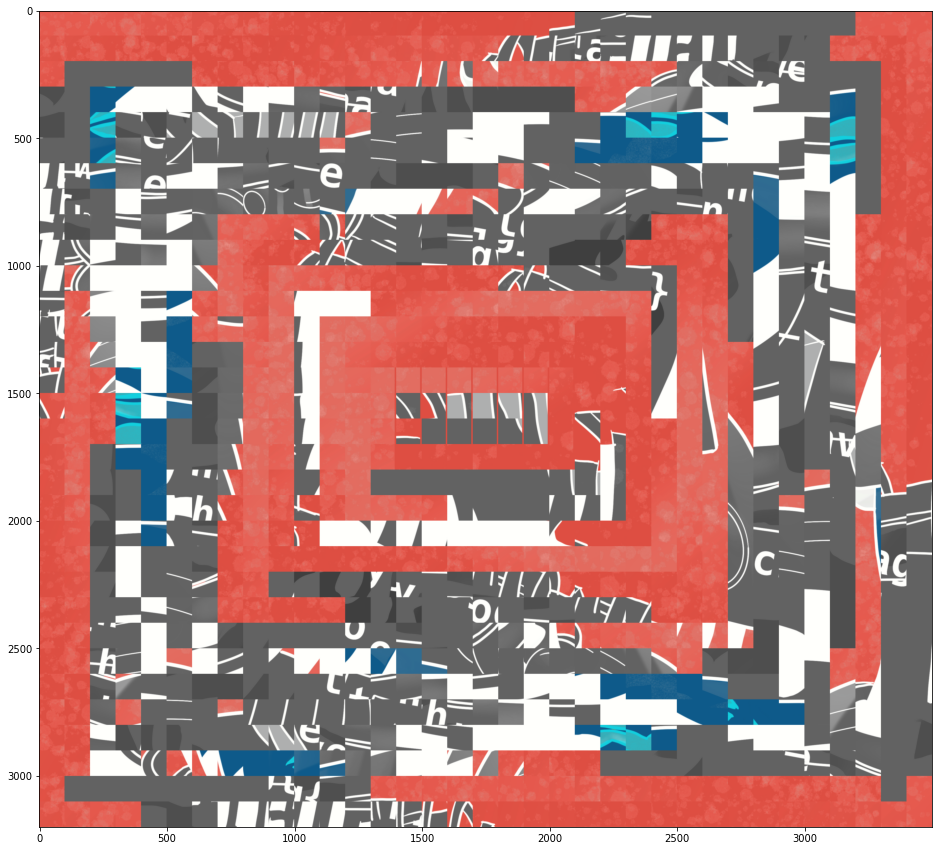

In [2]:
# Let's have a look at this image:
image_file_loc = r"C:\Users\josep\Pictures\Camera Roll\scrambled.png"
image_file = image.imread(image_file_loc)

print(image_file.shape)
plt.figure(figsize=(16,16))
plt.imshow(image_file);
# Looks like the image is broken up into 100 x 100 pixel chunks.


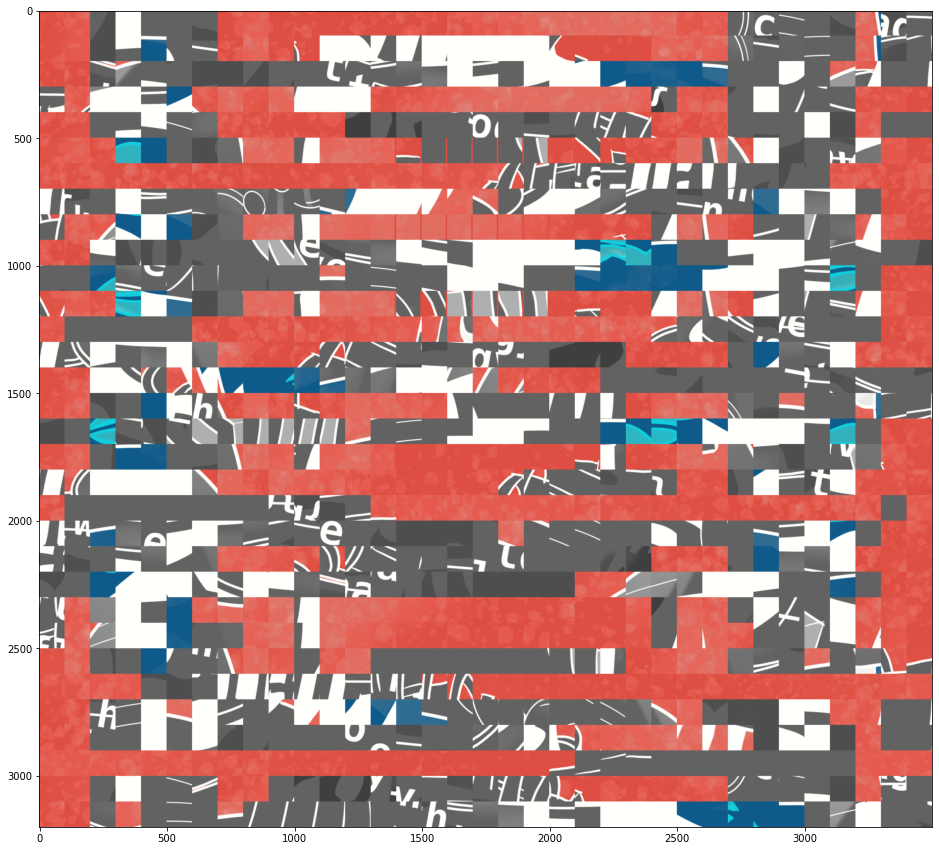

In [40]:
reshaped_image = np.reshape(image_file, (32,35,100,100,3))

permuted_image = np.random.permutation(reshaped_image)


plt.figure(figsize=(16,16))
plt.imshow(permuted_image.reshape(image_file.shape));
# Random permutations don't seem to be leading to anything meaningful. Investigate algorithms.

In [69]:
import scipy.fftpack as fftpack


def gridded_image_entropy(image, grid_size=3):
    entropies = [[None]*(image.shape[1] - grid_size + 1)]*(image.shape[0] - grid_size + 1)

    for ii in range(len(entropies)):

        for jj in range(len(entropies[ii])):

            this_block = image[ii:ii+grid_size, jj:jj+grid_size]

            marg = np.histogramdd(np.ravel(this_block), bins=256)[0]/this_block.size
            marg = list(filter(lambda p: p > 0, np.ravel(marg)))

            entropies[ii][jj] = -np.sum(np.multiply(marg, np.log2(marg)))

    return np.mean(entropies)


def random_reconstruct(image, grid_size_max=5, iters=10_000):

    old_entropy = gridded_image_entropy(image, 2)
    old_image = np.copy(image)
    for grid_size in range(grid_size_max+1, 2, -1):
        for ii in range(iters):
            next_image = np.random.permutation(old_image)
            next_entropy = gridded_image_entropy(next_image)
            if next_entropy > old_entropy:
                continue
            old_image = np.copy(next_image)
            old_entropy = next_entropy
        
        return old_image

def fourier_reconstruct(image, og_dims, iters=10_000):
    old_freq = np.max(np.abs(fftpack.fft2(image.reshape(og_dims))))
    old_image = np.copy(image)
    for ii in range(iters):
        new_image = np.random.permutation(old_image)
        new_freq = np.max(np.abs(fftpack.fft2(old_image.reshape(og_dims))))
        
        if new_freq > old_freq:
            print(ii)
            continue

        old_image = np.copy(new_image)
        old_freq = new_freq
    return old_image


# Algorithm via entropy computation doesn't seem to be working either. Consider Fourier tranforms.

98961.03594337226
105089.67490366758
105159.64363573345
104578.26815123468
104163.58585551605
105474.74925910271
104737.88672249057
103654.90057539417
104335.48213002642
105174.37159397057
103361.68483954718
105079.73070320176
105118.44030885164
104722.6318421654
103393.85539297301
105332.54256839649
104565.92878404532
103926.82069464914
103841.38565880759
105197.22394200957
104960.12708669173
104594.47224029471
105119.59419243972
104224.71333730547
105199.06095855555
103808.7813722786
104709.44706157541
104201.82250401191
104607.71141339745
103502.52245852527
104540.10520061184
104847.28845823837
104904.12252616165
104301.94334725435
105163.53321609389
105096.71318614659
104899.22741429276
105688.07925602421
104407.66402943536
105195.59223513587
105883.95581963658
104016.02236494182
104404.86450630159
103474.51255098697
105206.67805817515
105207.57777826194
104551.15514839426
104609.48842297203
104258.69254026066
105357.23041738823
104268.80682864285
105016.37227894441
104621.66362183

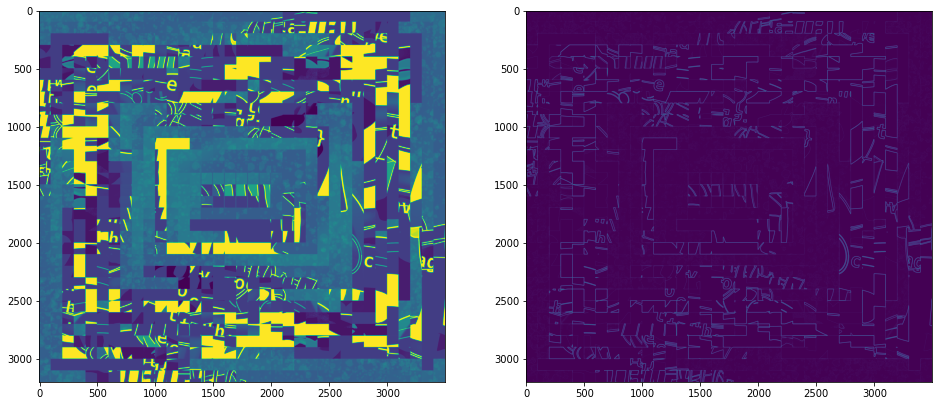

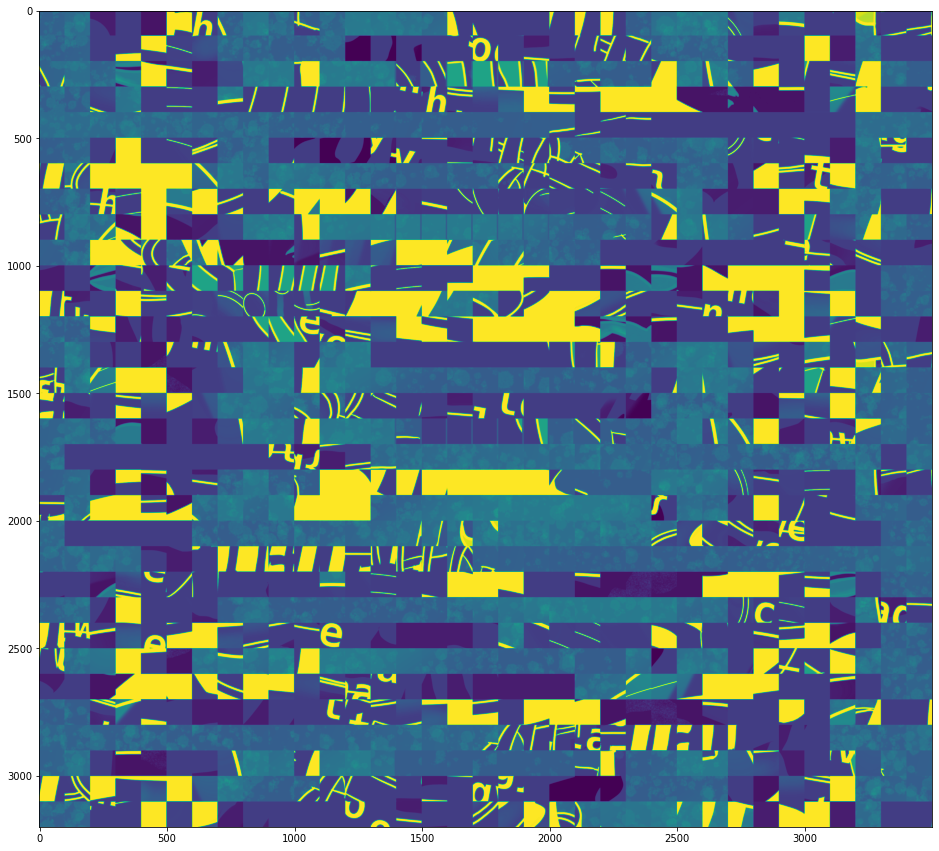

In [38]:

gray_image = np.sum(image_file*np.array([.2989, .5870, .1140]), axis=-1)
spectrum = fftpack.dctn(gray_image)

segmented_image = np.reshape(gray_image, (32,35,100,100))

# new_try = fourier_reconstruct(segmented_image, gray_image.shape, iters=10000)

grad = np.gradient(gray_image)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.imshow(gray_image);
ax2.imshow(np.linalg.norm(grad, axis=0));


new_try = grad_reconstruct(gray_image, gray_image.shape, (32,35,100,100), iters=500)

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(new_try)

# Fourier is not getting it done; now to try something a little more low tech.

In [24]:
from itertools import permutations
from copy import deepcopy

def reconstruct_by_permutation(block_list, threshold=.7):
    if len(block_list) < 2:
        return block_list
    
    double_list = []

    for p in permutations(block_list, 2):
        l_block, r_block = p
        if np.mean(np.equal(l_block[:, -1], r_block[:, 0])) > threshold:
            double_list.append(np.concatenate((l_block, r_block), axis=1))

    new_block_list = []

    for p in permutations(double_list, 2):
        t_block, b_block = p
        if np.mean(np.equal(t_block[-1, :], b_block[0, :])) > threshold:
            new_block_list.append(np.concatenate((t_block, b_block), axis=0))

    del double_list
    print([b.shape for b in new_block_list])
    return reconstruct_by_permutation(new_block_list)



block_list = []
[[block_list.append(b) for b in a] for a in segmented_image]


result = reconstruct_by_block(block_list)

1


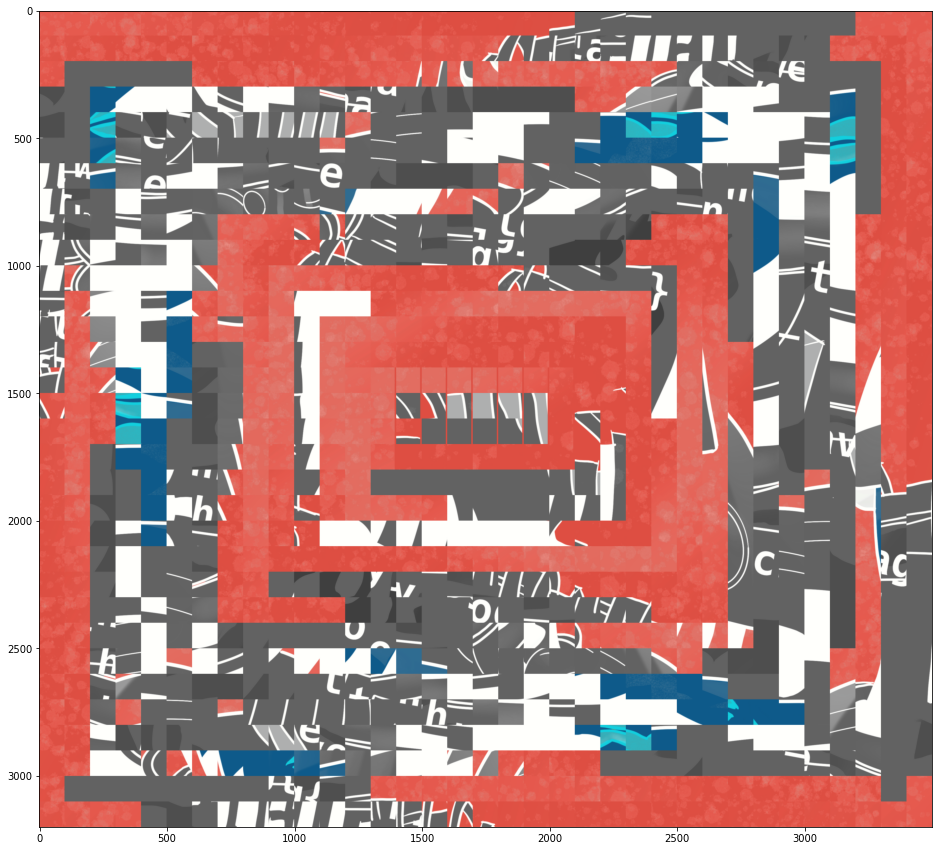

In [51]:

def energy_interface(blocked_image):
    og_shape = blocked_image.shape
    n_rows, n_cols = og_shape[0]+2, og_shape[1]+2
    new_shape = (n_rows, n_cols, *og_shape[2:])

    new_image = np.zeros(new_shape)
    new_image[1:-1, 1:-1,...] = blocked_image

    score = 0    

    for ii in range(1, n_rows-1):
        for jj in range(1, n_cols-1):
            score += np.sum(np.abs(new_image[ii-1, jj] + new_image[ii+1,jj] + new_image[ii, jj-1] + new_image[ii, jj+1] - 4*new_image[ii,jj]))

    return score

def grad_reconstruct(image, iters=10_000):

    old_image = np.copy(image)
    old_energy = energy_interface(old_image)
    
    for ii in range(iters):
        next_image = np.random.permutation(old_image)
        next_energy = energy_interface(next_image)
        
        if next_energy > old_energy:
            continue

        old_image = np.copy(next_image)
        old_energy = next_energy
    
    return old_image


plt.figure(figsize=(16,16))
plt.imshow(grad_reconstruct(reshaped_image, iters=1000).reshape(image_file.shape))